# Optimización de semáforos para control de tráfico vehicular usando procesos de decisión de markov

Autores: 
- Daniel Alejandro García Hernández
- David Camilo Cortes Salazar

En este notebook se encuentra una implementación de un algoritmo de Q-Learning para un modelo de interseccion vehicular sencillo.

Las librerías necesarias para ejectuar el código son:

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

Inicializamos las siguientes variables de entorno con el fin de modelar nuestro problema:

- max_carros: Representa el maximo de carros que puede haber en cada fila
  
- lambda_ns: Tasa de llegada para autos en sentido Norte-Sur
- lambda_sn: Tasa de llegada para autos en sentido Sur-Norte
- lambda_eo: Tasa de llegada para autos en sentido Este-Oeste
- lambda_oe: Tasa de llegada para autos en sentido Oeste-Este
  
- acciones: Representa las acciones que puede tomar el agente. 0 Para manetener en verde una via y 1 para dar luz verde a la via contraria y luz roja a la actual.

In [6]:

max_carros = 10
lambda_ns = 0.2  # Tasa de llegada para Norte-Sur
lambda_sn = 0.15  # Tasa de llegada para Norte-Sur
lambda_eo = 0.1  # Tasa de llegada para Este-Oeste
lambda_oe = 0.1  # Tasa de llegada para Este-Oeste
acciones = [0, 1]  # Mantener y cambiar


Generamos el espacio de estados. Esto no supone un problema a nivel de memoria pues al tener maximo 10 autos por fila habran 29282 estados en total:

In [7]:
# Generamos todos los estados posibles
estados = []
for n in range(max_carros + 1):
    for m in range(max_carros + 1):
        for k in range(max_carros + 1):
            for t in range(max_carros + 1):
                for s in [0, 1]:
                    estados.append((n, m, k, t, s))


Como nuestro espacio de estados es manejable, podemos generar la Q-table de manera estatica y asi simplificar el codigo del entrenamiento

In [8]:
# Inicializar la tabla Q con ceros
Q_table = {}
for estado in estados:
    Q_table[estado] = np.zeros(len(acciones))


### Algortimo

Para nuestro algoritmo de Q-Learning necesitamos apoyarnos de unas variables de aprendizaje como se describen a continuacion:

- alpha: Representa la tasa de aprendizaje del agente.
- gamma: Representa el valor de descuento para recompensas.
- simulaciones: Son los episodios con los que el agente sera entrenado.

Ademas, definiremos unos parametros para nuestro $\epsilon$ de la siguiente manera:

- epsilon_inicial: Es el valor que toma nuestro $\epsilon$ al inicio del entrenamiento.
- epsilon_final: Es el valor mas pequeño que puede tomar nuestro $\epsilon$ durante el entrenamiento.
- epsilon_decre: Define el decrecimiento de nuestro $\epsilon$ con el paso de cada episodio. Se define como:

$$\frac{\epsilon_{final}}{\epsilon_{inicial}}^{\frac{1}{0.8\times E}}$$

Donde $E$ es el numero de episodios (en nuestro caso, la variable simulaciones).

Esto nos servira para usar una estrategia $\epsilon$-greedy en nuestro algoritmo donde en los primeros episodios se priorice la exploracion de nuevos estados y a medida que se avance en el tiempo, la prioridad del agente cambie a la explotacion de los valores calculados durante la exploracion.

In [15]:

alpha = 0.2 # Tasa de aprendizaje (entre 0.1 y 0.5) (valores altos -> rapido e insetable) (valores bajos -> lento y estable)
gamma = 0.95  # Factor de descuento (entre 0.9 y 0.99) (valores altos -> recompensas a futuro) (valores bajos -> recompensas cercanas)
epsilon_inicial = 1.0
epsilon_final = 0.01
simulaciones = 10000

decre_simulacion = int(simulaciones * 0.8) 
epsilon_decre = (epsilon_final / epsilon_inicial) ** (1 / decre_simulacion)


La funcion de transicion de nuestro agente define los pasos en tiempo discreto de nuestro modelo. Aqui, en cada cambio de estado, solo un auto puede salir de la fila en la que se encuentra si el semaforo esta en verde en su via o cambio a verde en ese momento. De esta manera, se le dara una recompensa de $1$ a nuestro agente por cada auto que pase pero se penalizara con $-0.5$ si la accion es cambiar el semaforo y no importa cual accion tome recibira $-0.1$ por cada auto que quede en espera.



In [16]:
def paso_discreto(estado, accion):
    n, m, k, t, s = estado
    recompensa = 0

    # Llegada de nuevos carros bajo Poisson
    nuevos_ns = np.random.poisson(lambda_ns)
    nuevos_eo = np.random.poisson(lambda_eo)
    nuevos_sn = np.random.poisson(lambda_sn)
    nuevos_oe = np.random.poisson(lambda_oe)

    n = min(n + nuevos_ns, max_carros)
    m = min(m + nuevos_eo, max_carros)
    k = min(k + nuevos_sn, max_carros)
    t = min(t + nuevos_oe, max_carros)

    # Si cambia
    if accion == 1:
        s = 1 - s  # Cambiar estado del semáforo
        recompensa -= 0.5  # penalizacion de cambio

    if s == 0: # Si esta en NS o SN
        if n > 0:
            n -= 1 # Pasa un auto
            recompensa += 1
        if k > 0:
            k -= 1 # Pasa un auto
            recompensa += 1
    elif s == 1:# Si esta en EO o OE
        if m > 0:    
            m -= 1 # Pasa un auto
            recompensa += 1
        if t > 0:    
            t -= 1 # Pasa un auto
            recompensa += 1

    # Penalizacion autos en espera
    recompensa -= 0.1 * (n + m + k + t)

    # Estado actualizado
    sig_estado = (n, m, k, t, s)

    return sig_estado, recompensa


Con todo lo anterior, solo queda implementar nuestro algoritmo de entrenamiento. Este funciona con los siguientes pasos en cada episodio:

1. Observa el estado actual.
   
2. Selecciona una accion mediante la estrategia $\epsilon$-greedy. Con probabilidad $\epsilon$ elige una accion aleatoria y con probabilidad $1-\epsilon$ la elige usando la politica actual.
3. Calcula las recompensas obtenidas con la decision tomada.
4. Cambia de estado segun la accion elegida

5. Actualiza la Q-table mediante la ecuacion:

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ R(s_t, a_t) + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right]$$

6. Si aun no termina el episodio actual, vuelve a **1.**. Si termino continua en **7.**

7. Actualiza el epsilon
   
8.  Pasa al siguiente episodio

In [17]:
epsilon = epsilon_inicial

# Analisis de recompensas
recompensas_simulaciones = [] # recompensas por simulacion

# Analisis de convergencia  
valores_delta_q = []
Q_table_anterior = None

# Analisis de politica
cambios_politica = []
politica_anterior = None

for simulacion in range(simulaciones):
    
    # Estado inicial aleatorio
    estado = (np.random.randint(0, max_carros + 1),
             np.random.randint(0, max_carros + 1),
             np.random.randint(0, max_carros + 1),
             np.random.randint(0, max_carros + 1),
             np.random.choice([0, 1]))

    terminar = False
    recompensa_total = 0
    pasos = 0

    while not terminar:
    
        if np.random.rand() < epsilon:
            accion = np.random.choice(acciones)
        else:
            accion = np.argmax(Q_table[estado]) 

        sig_estado, recompensa = paso_discreto(estado, accion)

        # Actualización de Q-learning
        sig_mejor_accion = np.argmax(Q_table[sig_estado])

        td_objetivo = recompensa + gamma * Q_table[sig_estado][sig_mejor_accion] # R + gamma * Q(St+1, a)
        td_error = td_objetivo - Q_table[estado][accion] # td_target - Q(S, A)

        Q_table[estado][accion] += alpha * td_error # Q(S, A) + alpha *  -> Actualiza probabilidad

        # Actualizar el estado
        estado = sig_estado
        pasos += 1

        # Condición para terminar el episodio
        if pasos >= 100:
            recompensa_total += recompensa
            terminar = True

    # Decaimiento de epsilon
    if epsilon > epsilon_final:
        epsilon *= epsilon_decre
    else:
        epsilon = epsilon_final

    # Analisis de Recompensas
    recompensas_simulaciones.append(recompensa_total)

    # Analsiis de Convergencia
    if Q_table_anterior is not None:
        delta_Q = 0
        for estado in Q_table:
            delta_Q += np.sum(np.abs(Q_table[estado] - Q_table_anterior[estado]))
        valores_delta_q.append(delta_Q / len(acciones)*len(estados))

        # Analisis de Politica
        cambios = sum(np.argmax(Q_table[estado]) != np.argmax(Q_table_anterior[estado]) for estado in Q_table)
        cambios_politica.append(cambios / len(estados))

    Q_table_anterior = deepcopy(Q_table)

    # Mostrar progreso cada 100 simulaciones
    if (simulacion + 1) % (simulaciones // 100) == 0:
        print(f'Episodio {simulacion + 1}/{simulaciones}, epsilon: {epsilon:.4f}')


Episodio 100/10000, epsilon: 0.9441
Episodio 200/10000, epsilon: 0.8913
Episodio 300/10000, epsilon: 0.8414
Episodio 400/10000, epsilon: 0.7943
Episodio 500/10000, epsilon: 0.7499
Episodio 600/10000, epsilon: 0.7079
Episodio 700/10000, epsilon: 0.6683
Episodio 800/10000, epsilon: 0.6310
Episodio 900/10000, epsilon: 0.5957
Episodio 1000/10000, epsilon: 0.5623
Episodio 1100/10000, epsilon: 0.5309
Episodio 1200/10000, epsilon: 0.5012
Episodio 1300/10000, epsilon: 0.4732
Episodio 1400/10000, epsilon: 0.4467
Episodio 1500/10000, epsilon: 0.4217
Episodio 1600/10000, epsilon: 0.3981
Episodio 1700/10000, epsilon: 0.3758
Episodio 1800/10000, epsilon: 0.3548
Episodio 1900/10000, epsilon: 0.3350
Episodio 2000/10000, epsilon: 0.3162
Episodio 2100/10000, epsilon: 0.2985
Episodio 2200/10000, epsilon: 0.2818
Episodio 2300/10000, epsilon: 0.2661
Episodio 2400/10000, epsilon: 0.2512
Episodio 2500/10000, epsilon: 0.2371
Episodio 2600/10000, epsilon: 0.2239
Episodio 2700/10000, epsilon: 0.2113
Episodio 2

### Evaluar rendimiento

En este punto tenemos una Q-table ya entrenada y lista para usarse en diferentes evaluaciones. Veamos que recompensa obtiene en algunas de ellas:

In [18]:
for i in range(10):
    estado = (np.random.randint(0, max_carros + 1),
            np.random.randint(0, max_carros + 1),
            np.random.randint(0, max_carros + 1),
            np.random.randint(0, max_carros + 1),
            np.random.choice([0, 1]))
    recompensa_total = 0
    pasos = 0
    max_pasos = 10**((i%3)+1)

    while pasos < max_pasos:
        accion = np.argmax(Q_table[estado])  # Seleccionar la mejor acción
        sig_estado, recompensa = paso_discreto(estado, accion)
        recompensa_total += recompensa
        estado = sig_estado
        pasos += 1

    print(f'Evaluacion: {i}\t Pasos: {max_pasos}:\t Recompensa total: {recompensa_total}')


Evaluacion: 0	 Pasos: 10:	 Recompensa total: 6.599999999999999
Evaluacion: 1	 Pasos: 100:	 Recompensa total: 28.599999999999984
Evaluacion: 2	 Pasos: 1000:	 Recompensa total: 374.99999999999943
Evaluacion: 3	 Pasos: 10:	 Recompensa total: 7.999999999999999
Evaluacion: 4	 Pasos: 100:	 Recompensa total: 51.699999999999974
Evaluacion: 5	 Pasos: 1000:	 Recompensa total: 368.1999999999992
Evaluacion: 6	 Pasos: 10:	 Recompensa total: 0.7999999999999989
Evaluacion: 7	 Pasos: 100:	 Recompensa total: 40.199999999999974
Evaluacion: 8	 Pasos: 1000:	 Recompensa total: 342.2999999999996
Evaluacion: 9	 Pasos: 10:	 Recompensa total: 4.999999999999998


Note que al definir $\alpha = 0.2$ como un valor pequeño, nuestro agente va a priorizar la obtencion de recompensas a largo plazo, por esto, en la evaluaciones donde solo ocurrieron 10 pasos la recompensa fue cercana a 0. La politica que el agente conoce esta pensada a futuro y por esto en las evaluaciones con mas pasos se puede ver como la recompensa aumenta bastante si se le da mas tiempo.

#### Cambio en Recompensas:

Veamos como evoluciono el calculo de recompensas durante la ejecucion del algoritmo:

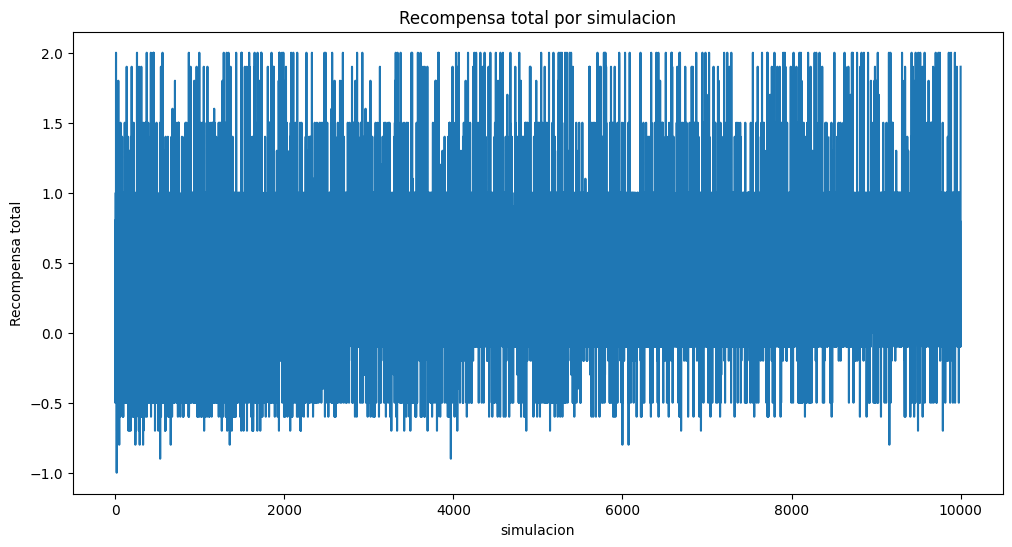

In [19]:

plt.figure(figsize=(12, 6))
plt.plot(recompensas_simulaciones)
plt.xlabel('simulacion')
plt.ylabel('Recompensa total')
plt.title('Recompensa total por simulacion')


#valor_minimo = np.percentile(recompensas_simulaciones, 5)
# = np.percentile(recompensas_simulaciones, 95)


plt.show()

#### Recompensa promedio:

Ahora nos interesa observar como se ve la ganancia de recompensas con el pasar del tiempo. Esto lo conseguimos con promedio movil de la forma:

$$ PM_{t} = \frac{1}{k} \sum_{i=t-k+1} x_{i}$$

Donde:

- $x_{i}$ es el valor de la recompensa en la simulacion $i$
- $t$ es la simulacion actual
- $k$ es el numero de datos a promediar, donde $k \geq t$

Este $k$ se conoce como tamaño de la ventana del promedio movil, y en nuestro caso lo tomamos como el 5% de las simualciones para tener un buen suavizado en los datos y no perder valores importantes

Ahora veamos como se ve este promedio para cada simulacion:

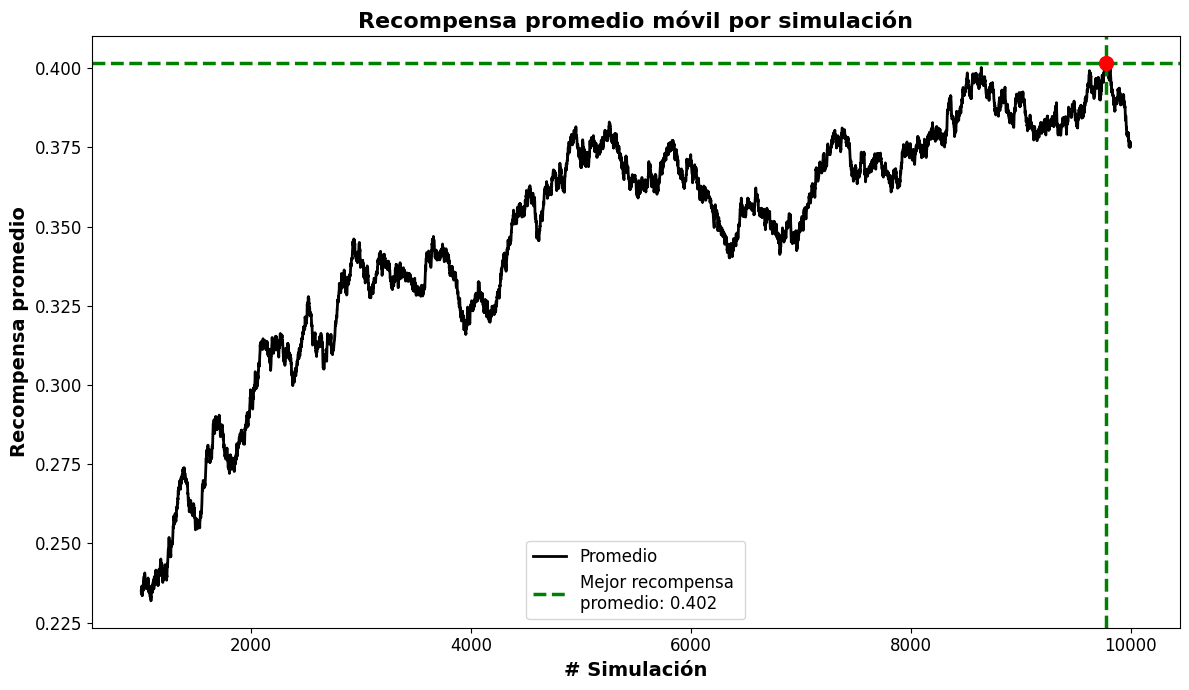

In [102]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'Recompensa_movil'
y_values = recompensas_simulaciones

size = int(simulaciones*0.10)
moving_avg = np.convolve(y_values, np.ones(size)/size, mode='valid')
max_index = np.argmax(moving_avg)
max_value = moving_avg[max_index]

plt.figure(figsize=(12, 7))

plt.plot(range(size, len(y_values)+1), moving_avg, color='k', linewidth=2, label='Promedio')

plt.scatter(max_index + size, max_value, color='red', marker='o', s=100, zorder=10)
plt.axvline(max_index + size, color='g', linestyle='--', linewidth=2.5)
plt.axhline(max_value, color='g', linestyle='--', label=f'Mejor recompensa \npromedio: {max_value:.3f}', linewidth=2.5)



#plt.ylim([np.min(moving_avg)*1.1, np.max(moving_avg)*1.1]) 

plt.title('Recompensa promedio móvil por simulación', fontsize=16, fontweight='bold')
plt.xlabel('# Simulación', fontsize=14, fontweight='bold')
plt.ylabel('Recompensa promedio', fontsize=14, fontweight='bold')


plt.tick_params(axis='both', which='major', labelsize=12)

#plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=12, loc='best')
plt.savefig(f'Imagenes/{filename}.svg')
plt.savefig(f'Imagenes/{filename}.pdf')

plt.show()

#### Cambio en valores de Q:

Definimos el cambio en los valores de Q como:

$$ \Delta Q = \frac{1}{|S| \times |A|} \sum_{s\in S} \sum_{a\in A} |Q_{t+1}(s,a) - Q_{t}(s,a)|

Donde:

- $|S|$ es el espacio de estados
- $|A|$ es el espacio de acciones
- $Q_{t}(s,a)$ es el valor de $Q$ dados $s$ y $a$ en la simulacion $t$

Ahora veamos este cambio graficamente atravez de las simulaciones:

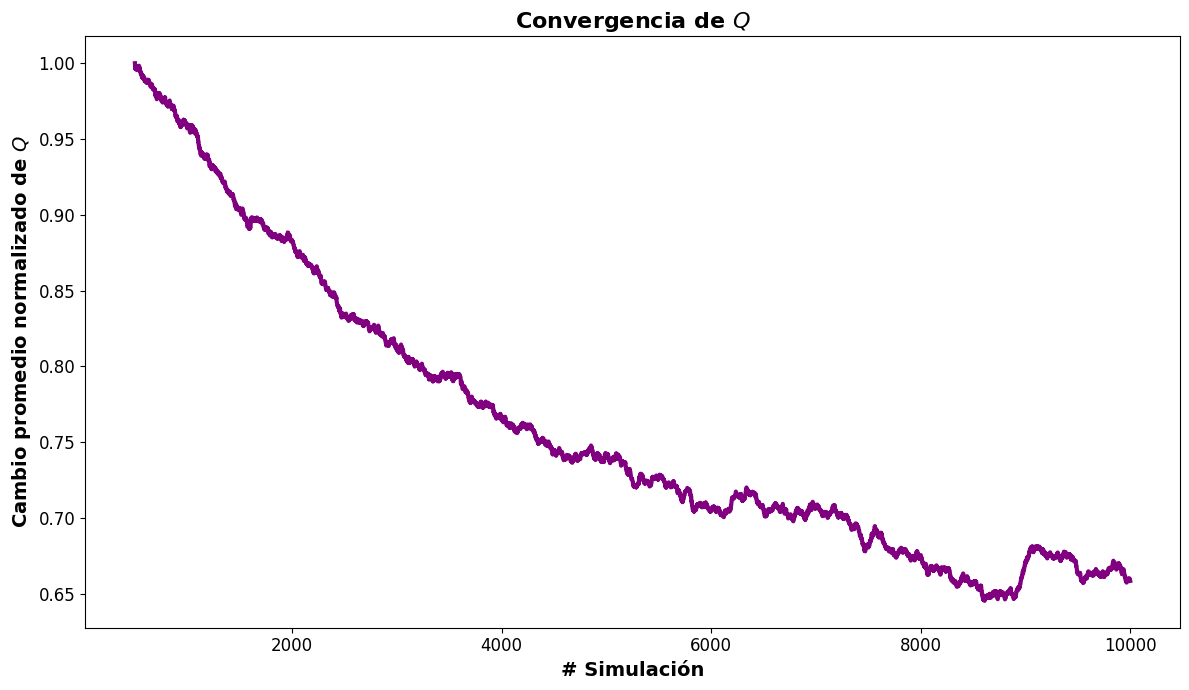

In [116]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'valores_delta_q'
y_values = valores_delta_q

size = int(simulaciones*0.05)
moving_avg = np.convolve(y_values, np.ones(size)/size, mode='valid')
max_index = np.argmax(moving_avg)
max_value = moving_avg[max_index]

plt.figure(figsize=(12, 7))

plt.plot(range(size, len(y_values)+1), moving_avg/max_value, color='purple', linewidth=3, label='Promedio')


#plt.ylim([np.min(moving_avg)*1.1, np.max(moving_avg)*1.1]) 

plt.title(r'Convergencia de $Q$', fontsize=16, fontweight='bold')
plt.xlabel('# Simulación', fontsize=14, fontweight='bold')
plt.ylabel(r'Cambio promedio normalizado de $Q$', fontsize=14, fontweight='bold')


plt.tick_params(axis='both', which='major', labelsize=12)

#plt.grid(True)
plt.tight_layout()
#plt.legend(fontsize=12, loc='best')

plt.savefig(f'Imagenes/{filename}.svg')
plt.savefig(f'Imagenes/{filename}.pdf')

plt.show()

Vemos como la diferencia entre valores de $Q$ decrece con el paso de las simulaciones, esto quiere decir que se acerca cada vez mas a una politica optima mediante el ajuste de valores en cada simulacion.

#### Cambios en politica:

Defininimos el cambio en la politica como:

$$ \Delta \delta = \sum_{s \in S} \frac{\delta (a_{t}(s), a_{t-1}(s))}{|S|} $$

Donde:

- $|S|$ es el espacio de estados
- $a_{t}(s)$ es la accion optima a tomar en el estado $s$ en la simulacion $t$
- $\delta(x_{1}, x_{2})$ es una funcion que vale 1 si la accion optima en el estado $s$ ha cambiado entre la simulacion $t$ y $t-1$, y 0 en otro caso.

Ahora veamos este cambio graficamente atravez de las simulaciones:

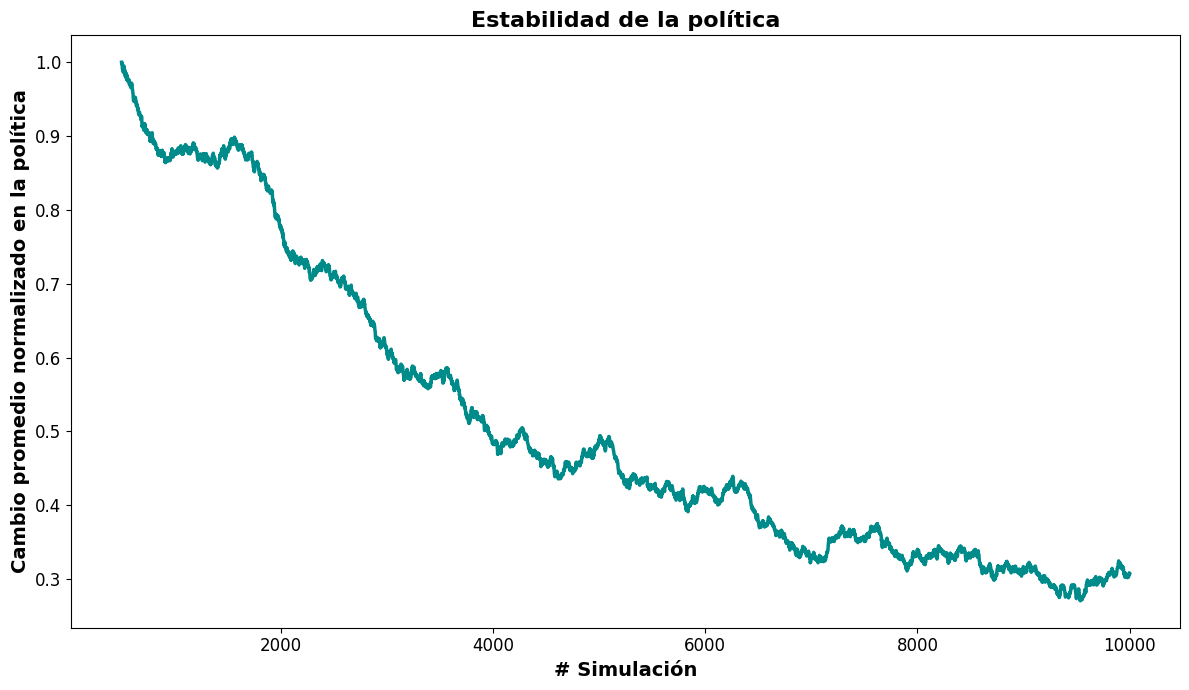

In [129]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'cambios_politica'
y_values = cambios_politica

size = int(simulaciones*0.05)
moving_avg = np.convolve(y_values, np.ones(size)/size, mode='valid')
max_index = np.argmax(moving_avg)
max_value = moving_avg[max_index]

plt.figure(figsize=(12, 7))

plt.plot(range(size, len(y_values)+1), moving_avg/max_value, color='darkcyan', linewidth=2.5, label='Promedio')


#plt.ylim([np.min(moving_avg)*1.1, np.max(moving_avg)*1.1]) 

plt.title(r'Estabilidad de la política', fontsize=16, fontweight='bold')
plt.xlabel('# Simulación', fontsize=14, fontweight='bold')
plt.ylabel(r'Cambio promedio normalizado en la política', fontsize=14, fontweight='bold')


plt.tick_params(axis='both', which='major', labelsize=12)

#plt.grid(True)
plt.tight_layout()
#plt.legend(fontsize=12, loc='best')

plt.savefig(f'Imagenes/{filename}.svg')
plt.savefig(f'Imagenes/{filename}.pdf')

plt.show()

Esta grafica nos da a entender que los cambios en la politica tienden a estabilizarse y ser cada vez mas pequeños a medida que avanza el algoritmo, esto nos interesa pues significa que esta hallando una politica que minimiza el tiempo de espera de los autos.